In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.constants as sc
from lmfit.models import LinearModel
from lmfit.model import save_modelresult

import matplotlib as mpl
import sqlite3

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
#mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
#mpl.rcParams['ps.fonttype'] = 42

### 4U thermometer dG DMS correlations

In [32]:
# Load DMS dG data
dms_dG = pd.read_csv('../08_dG_barplots/fourU_calc_dG.csv')[['site', 'disp_name', 'site_nt', 'dG', 'dG_err']]
dms_ddG = pd.read_csv('../08_dG_barplots/fourU_calc_ddG.csv')

In [33]:
dms_dG

,site,disp_name,site_nt,dG,dG_err
0,7,4U_wt,7A,1.086420,0.072888
1,8,4U_wt,8A,1.073381,0.075067
2,15,4U_wt,15A,1.784226,0.076196
3,16,4U_wt,16A,1.969192,0.080283
4,22,4U_wt,22A,1.427904,0.075436
5,26,4U_wt,26A,2.104654,0.078518
6,29,4U_wt,29A,2.133948,0.072890
7,34,4U_wt,34A,1.796252,0.096091
8,35,4U_wt,35A,1.661955,0.081128
9,7,4U_a8c,7A,2.096431,0.104969


In [34]:
# Calc raw endpt at 10 mins

# Load data
global_fits = '../06_aggfit_ntp_adduction/reference/EKC.01.061.analyze_fit_distributions/global_refit_results_withCs.db'

conn = sqlite3.connect(global_fits)
query = 'SELECT * FROM global_fits'
fits = pd.read_sql_query(query, conn)

# get experimental info
main_db  = '../06_aggfit_ntp_adduction/reference/EKC.01.060.developing_DB_input/new.db'
conn = sqlite3.connect(main_db)
query = """
    SELECT pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM reaction_groups rg
    JOIN constructs c ON pr.construct_id = c.id
    LEFT JOIN probing_reactions pr ON rg.rxn_id = pr.id
    WHERE pr.RT = 'MRT'
    GROUP BY rg.rg_id
"""
exp_info = pd.read_sql_query(query, conn)
fits['rg_id'] = fits['rg_id'].astype(int)
fits = fits.merge(exp_info, left_on='rg_id', right_on='rg_id', how='left')

# drop duplicates
fits = fits.drop_duplicates()
# filter fits to under 85C
fits = fits[fits['temperature'] < 85]
fits

def fmod_model(x, log_kappa, log_kdeg, log_fmod_0):
    kappa = np.exp(log_kappa)
    kdeg = np.exp(log_kdeg)
    fmod_0 = np.exp(log_fmod_0)
    return 1 - np.exp(- (kappa) * (1 - np.exp(-kdeg * x))) + fmod_0

fits['endpt_10mins'] = fmod_model(10 * 60, fits['log_kappa'], fits['log_kdeg'], fits['log_fmod_0'])
fits = fits[['site', 'temperature', 'disp_name', 'buffer_id', 'endpt_10mins']]
fits['lnendpt_10mins'] = - np.log(fits['endpt_10mins'])

# filter to structs containing '4U_' and temp 20
fits = fits[fits['disp_name'].str.contains('4U_')]
fits = fits[fits['temperature'] == 20]

dms_endpt = fits.copy()
dms_endpt
# mlogb pseudofree energy


,site,temperature,disp_name,buffer_id,endpt_10mins,lnendpt_10mins
1135,2,20,4U_a8c,1,0.000724,7.231115
1136,3,20,4U_a8c,1,0.000498,7.605282
1137,6,20,4U_a8c,1,0.000768,7.171506
1138,7,20,4U_a8c,1,0.001034,6.874716
1139,14,20,4U_a8c,1,0.000310,8.078547
...,...,...,...,...,...,...
7226,25,20,4U_a8c,1,0.001708,6.372263
7251,9,20,4U_wt,1,0.005147,5.269407
7252,9,20,4U_wt,1,0.004953,5.307784
7253,25,20,4U_wt,1,0.001519,6.489741


In [35]:
# Preprocess imino proton NMR data
imino_proton = pd.read_csv('../09_dG_correlations/reference/imino_ref_values.csv')
imino_proton = imino_proton[['site_comp', 'var', 'dG', 'dG_err']]
# convert dG and dG_err to kcal/mol
imino_proton['dG'] = imino_proton['dG'] / sc.calorie
imino_proton['dG_err'] = imino_proton['dG_err'] / sc.calorie
# replace 'var' 'A8C' to '4U_a8c' and 'WT' to '4U_wt'
imino_proton['var'] = imino_proton['var'].replace({'A8C': '4U_a8c', 'WT': '4U_wt'})

In [36]:
def calculate_r2_from_fit(merged_dG, x_col = 'dG', y_col = 'dG_imino', x_label = 'DMS', y_label = 'NMR'):
    linear_model = LinearModel()
    params = linear_model.guess(merged_dG[y_col], x=merged_dG[x_col])
    result = linear_model.fit(merged_dG[y_col], params, x=merged_dG[x_col])

    # calculate r2
    r2 = result.rsquared
    return r2

def plot_linear_correlation(merged_dG, x_col = 'dG', y_col = 'dG_imino', x_err_col = 'dG_err', y_err_col = 'dG_err_imino', x_label = 'DMS', y_label = 'NMR', construct = '4U', temp = 20):
    linear_model = LinearModel()
    params = linear_model.guess(merged_dG[y_col], x=merged_dG[x_col])
    result = linear_model.fit(merged_dG[y_col], params, x=merged_dG[x_col])

    # pretty print result
    print(result.fit_report())

    # save model fit parameters to json
    save_modelresult(result, f'{construct}_{y_label}_v_{x_label}_fit.sav')

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(merged_dG[x_col], merged_dG[y_col], color = 'black', s = 15)
    ax.plot(merged_dG[x_col], result.best_fit, color = 'black', linewidth = 1)

    # plot errors
    for i in range(len(merged_dG)):
        x = merged_dG[x_col].iloc[i]
        y = merged_dG[y_col].iloc[i]
        x_err = merged_dG[x_err_col].iloc[i]
        y_err = merged_dG[y_err_col].iloc[i]
        ax.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='none', color='black', capsize=1, elinewidth=0.5)

    label = r'$\Delta G_{XXX, TTT°C}$ (kcal/mol)'
    label = label.replace('TTT', str(temp))

    ax.set_xlabel(label.replace('XXX', x_label))
    ax.set_ylabel(label.replace('XXX', y_label))

    if x_label == 'endpt':
        ax_set_xlabel('ln(Mut. Rate)')
    elif x_label == 'endpt2':
        ax.set_xlabel('Pseudo-free energy (kcal/mol)')
    if y_label == 'endpt':
        ax.set_ylabel('ln(Mut. Rate)')
    elif y_label == 'endpt2':
        ax.set_ylabel('Pseudo-free energy (kcal/mol)')

    # set ylim 1 to 5
    ax.set_ylim(1, 5)

    # annotate r2 bottom left
    r2 = result.rsquared
    ax.annotate(f'$r^2$ = {r2:.2f}', xy=(0.95, 0.05), xycoords='axes fraction', fontsize=15, ha='right', va='bottom')
    plt.tight_layout()
    plt.savefig(f'{construct}_{y_label}_v_{x_label}.pdf')
    print('Saving figure as ' + f'{construct}_{y_label}_v_{x_label}.pdf')
    plt.show()

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 16
    # variables        = 2
    chi-square         = 2.94524785
    reduced chi-square = 0.21037485
    Akaike info crit   = -23.0783320
    Bayesian info crit = -21.5331546
    R-squared          = 0.70312540
[[Variables]]
    slope:      0.29984179 +/- 0.05207128 (17.37%) (init = 0.2998418)
    intercept:  1.21450822 +/- 0.26470957 (21.80%) (init = 1.214508)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9013
Saving figure as 4U_DMS_v_NMR.pdf


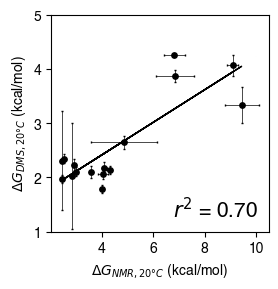

In [37]:
## Imino NMR vs DMS corr.

merged_dG = dms_dG.merge(imino_proton, left_on = ['site', 'disp_name'], right_on=['site_comp', 'var'], how='inner', suffixes=('', '_imino')).sort_values(by=['site', 'disp_name'])
merged_dG.to_csv('merged_dG.csv', index=False)

plot_linear_correlation(merged_dG, 'dG_imino', 'dG','dG_err_imino',  'dG_err', 'NMR', 'DMS', '4U')

In [38]:
def preprocess_nn_pen(csv_file):
    nn_pen_df = pd.read_csv(csv_file)

    nn_pen_df['bp_res1'] -= 18
    nn_pen_df['bp_res2'] -= 18

    def get_ACsite(bp_res1, bp_base1, bp_res2, bp_base2):
        if bp_base1 == 'A' or bp_base1 == 'C':
            return bp_res1
        elif bp_base2 == 'A' or bp_base2 == 'C':
            return bp_res2
        else:
            return -1

    nn_pen_df['site'] = nn_pen_df.apply(lambda row: get_ACsite(row['bp_res1'], row['bp_base1'], row['bp_res2'], row['bp_base2']), axis=1)
    return nn_pen_df[nn_pen_df['site'] != -1][['site', 'energy_diff', 'err']]

nn_pen1_wt = preprocess_nn_pen('../09_dG_correlations/reference/01.061.002.correlation_dms_dG/fourU_WT_energy_calc.csv')
nn_pen1_a8c = preprocess_nn_pen('../09_dG_correlations/reference/01.061.002.correlation_dms_dG/fourU_A8C_energy_calc.csv')
nn_pen1_wt['var'] = '4U_wt'
nn_pen1_a8c['var'] = '4U_a8c'
nn_pen1 = pd.concat([nn_pen1_wt, nn_pen1_a8c], ignore_index=True)
nn_pen1.rename(columns={'energy_diff': 'dG', 'err': 'dG_err'}, inplace=True)
nn_pen1

,site,dG,dG_err,var
0,22,1.7,1.2,4U_wt
1,16,4.6,1.2,4U_wt
2,15,4.9,1.2,4U_wt
3,25,7.3,1.2,4U_wt
4,26,4.1,1.2,4U_wt
5,29,5.3,1.2,4U_wt
6,9,3.7,1.7,4U_wt
7,7,0.3,1.5,4U_wt
8,34,4.3,1.2,4U_wt
9,35,4.8,1.2,4U_wt


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 59
    # variables        = 2
    chi-square         = 202.464631
    reduced chi-square = 3.55201108
    Akaike info crit   = 76.7486383
    Bayesian info crit = 80.9037132
    R-squared          = 0.05471934
[[Variables]]
    slope:      0.70653203 +/- 0.38895952 (55.05%) (init = 0.706532)
    intercept:  8.87237644 +/- 2.60847580 (29.40%) (init = 8.872376)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = +0.9956
Saving figure as 4U_endpt_v_NMR.pdf


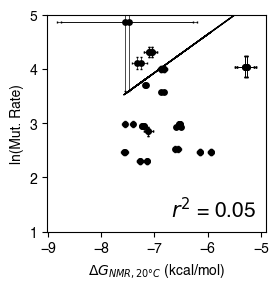

In [39]:
## Imino NMR vs DMS (endpt) corr.

merged_endpt = dms_endpt.merge(imino_proton, left_on = ['site', 'disp_name'], right_on=['site_comp', 'var'], how='inner', suffixes=('', '_imino')).sort_values(by=['site', 'disp_name'])
merged_endpt['lnendpt_10mins'] = - merged_endpt['lnendpt_10mins']
#merged_dG.to_csv('merged_dG.csv', index=False)

plot_linear_correlation(merged_endpt, 'lnendpt_10mins', 'dG','dG_err',  'dG_err', 'NMR', 'endpt', '4U')

In [40]:


def normalize_shape_20_80(df, colname, new_colname='shape_norm', cap=1.5):
    """
    Applies 20–80 normalization to a column of SHAPE reactivities in a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the SHAPE data
    - colname: name of the column with raw SHAPE reactivities
    - new_colname: name for the new column with normalized reactivities
    - cap: upper cap for normalized values (default 1.5)

    Returns:
    - df: DataFrame with a new column of normalized reactivities
    """

    # Extract positive reactivities only
    reactivities = df[colname]
    positive_vals = reactivities[reactivities > 0].dropna()

    if len(positive_vals) < 2:
        raise ValueError("Not enough positive values to compute 20–80 normalization.")

    # Compute 20th and 80th percentiles
    r20 = np.percentile(positive_vals, 20)
    r80 = np.percentile(positive_vals, 80)

    if r80 == r20:
        raise ValueError("20th and 80th percentiles are equal; cannot normalize.")

    # Normalize using 20–80 formula
    def normalize(val):
        if pd.isna(val) or val <= 0:
            return 0.0
        norm = (val - r20) / (r80 - r20)
        return max(0.0, min(norm, cap))  # cap and floor

    df[new_colname] = reactivities.apply(normalize)
    return df

def calc_corr_pseudofreenenergy(dms_endpt, m, b, imino_proton):
    pseudo_dms = normalize_shape_20_80(dms_endpt, 'endpt_10mins', 'norm_endpt')
    pseudo_dms['new'] = m * np.log(pseudo_dms['norm_endpt'] + 1) + b
    
    ## Imino NMR vs DMS (endpt) corr.
    merged_endpt = pseudo_dms.merge(imino_proton, left_on = ['site', 'disp_name'], right_on=['site_comp', 'var'], how='inner', suffixes=('', '_imino')).sort_values(by=['site', 'disp_name'])
    #merged_dG.to_csv('merged_dG.csv', index=False)

    plot_linear_correlation(merged_endpt, 'new', 'dG','dG_err',  'dG_err', 'NMR', 'endpt2', '4U')

# for slopes in 0-5, intercept -3 to 0, 25 levels on each axis, calculate correlation and save in matrix to plot on heatmap
#calc_corr_pseudofreenenergy(dms_endpt, 2.6, -1.1, imino_proton)

pseudo_dms = normalize_shape_20_80(dms_endpt, 'endpt_10mins', 'norm_endpt')
pseudo_dms['dG'] = 2.6 * np.log(pseudo_dms['norm_endpt'] + 1) + (-1.1)



In [41]:
merged_endpt

,site,temperature,disp_name,buffer_id,endpt_10mins,lnendpt_10mins,site_comp,var,dG,dG_err
0,6,20,4U_a8c,1,0.000768,-7.171506,6,4U_a8c,3.697419,0.023901
9,6,20,4U_a8c,1,0.000777,-7.160135,6,4U_a8c,3.697419,0.023901
18,6,20,4U_wt,1,0.000697,-7.269244,6,4U_wt,2.294455,0.047801
26,6,20,4U_wt,1,0.000788,-7.145685,6,4U_wt,2.294455,0.047801
34,6,20,4U_wt,1,0.000697,-7.269242,6,4U_wt,2.294455,0.047801
42,6,20,4U_wt,1,0.000788,-7.145686,6,4U_wt,2.294455,0.047801
1,7,20,4U_a8c,1,0.001034,-6.874716,7,4U_a8c,3.580306,0.033461
10,7,20,4U_a8c,1,0.001098,-6.814424,7,4U_a8c,3.580306,0.033461
50,8,20,4U_a8c,1,0.001713,-6.369796,8,4U_a8c,9.443117,0.662046
51,8,20,4U_a8c,1,0.001702,-6.375843,8,4U_a8c,9.443117,0.662046


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 59
    # variables        = 2
    chi-square         = 208.926837
    reduced chi-square = 3.66538311
    Akaike info crit   = 78.6023545
    Bayesian info crit = 82.7574294
    R-squared          = 0.02454815
[[Variables]]
    slope:      0.46061993 +/- 0.38459076 (83.49%) (init = 0.4606199)
    intercept:  4.42000046 +/- 0.33319104 (7.54%) (init = 4.42)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = +0.6636
Saving figure as 4U_endpt2_v_NMR.pdf


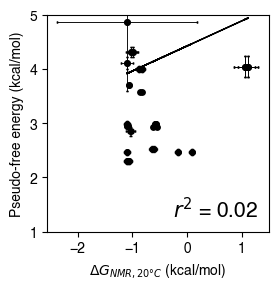

In [42]:
## Imino NMR vs DMS (endpt) corr.

merged_endpt = pseudo_dms.merge(imino_proton, left_on = ['site', 'disp_name'], right_on=['site_comp', 'var'], how='inner', suffixes=('', '_imino')).sort_values(by=['site', 'disp_name'])
#merged_dG.to_csv('merged_dG.csv', index=False)

plot_linear_correlation(merged_endpt, 'dG', 'dG_imino','dG_err',  'dG_err', 'NMR', 'endpt2', '4U')

In [43]:
# preprocess nn ensemble
mathews_dir = '../09_dG_correlations/reference/01.064.mathews_NN_energies'

fourU_constructs = {'A8C': '4U_a8c', 'WT': '4U_wt'}
fourU_ensemble = pd.DataFrame()

for construct, var in fourU_constructs.items():
    mathews_df = pd.read_csv(f'{mathews_dir}/{construct}ensemble.out', sep = '\t')
    mathews_df.rename(columns={'nucleotide#': 'site', 'DG': 'dG'}, inplace=True)
    mathews_df['dG_err'] = 0
    mathews_df['var'] = var
    mathews_df = mathews_df[['site', 'var', 'dG', 'dG_err']]
    fourU_ensemble = pd.concat([fourU_ensemble, mathews_df], ignore_index=True)

fourU_ensemble = fourU_ensemble[['site', 'var', 'dG', 'dG_err']]
fourU_ensemble

,site,var,dG,dG_err
0,1,4U_a8c,0.00,0
1,7,4U_a8c,5.38,0
2,8,4U_a8c,7.39,0
3,9,4U_a8c,7.29,0
4,15,4U_a8c,4.77,0
5,16,4U_a8c,2.81,0
6,18,4U_a8c,0.00,0
7,22,4U_a8c,1.65,0
8,25,4U_a8c,7.19,0
9,26,4U_a8c,4.09,0


In [44]:
# preprocess nn ablation
mathews_dir = '../09_dG_correlations/reference/01.064.mathews_NN_energies'

fourU_constructs = {'A8C': '4U_a8c', 'WT': '4U_wt'}
fourU_ablation = pd.DataFrame()

for construct, var in fourU_constructs.items():
    mathews_df = pd.read_csv(f'{mathews_dir}/{construct}ablation.out', sep = '\t')
    mathews_df.rename(columns={'nucleotide#': 'site', 'DG': 'dG'}, inplace=True)
    mathews_df['dG_err'] = 0
    mathews_df['var'] = var
    mathews_df = mathews_df[['site', 'var', 'dG', 'dG_err']]
    fourU_ablation = pd.concat([fourU_ablation, mathews_df], ignore_index=True)

fourU_ablation = fourU_ablation[['site', 'var', 'dG', 'dG_err']]
fourU_ablation

,site,var,dG,dG_err
0,7,4U_a8c,1.5,0
1,8,4U_a8c,3.9,0
2,9,4U_a8c,3.9,0
3,15,4U_a8c,1.2,0
4,16,4U_a8c,1.2,0
5,18,4U_a8c,1.1,0
6,22,4U_a8c,2.1,0
7,25,4U_a8c,3.8,0
8,26,4U_a8c,1.7,0
9,29,4U_a8c,1.9,0


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 21
    # variables        = 2
    chi-square         = 3.72372775
    reduced chi-square = 0.19598567
    Akaike info crit   = -32.3257409
    Bayesian info crit = -30.2366961
    R-squared          = 0.75472046
[[Variables]]
    slope:      0.40963355 +/- 0.05357428 (13.08%) (init = 0.4096336)
    intercept:  0.40381104 +/- 0.26826652 (66.43%) (init = 0.403811)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9329
Saving figure as 4U_DMS_v_NNpen.pdf


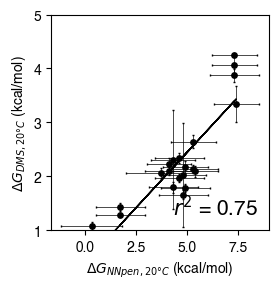

In [45]:
# NNpen vs. DMS correlation
merged_nnpen_dms = dms_dG.merge(nn_pen1, left_on=['site', 'disp_name'], right_on=['site', 'var'], how='inner', suffixes=('', '_nnpen')).sort_values(by=['site', 'disp_name'])
plot_linear_correlation(merged_nnpen_dms, 'dG_nnpen', 'dG', 'dG_err_nnpen', 'dG_err', 'NNpen', 'DMS', '4U', 20)

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 22
    # variables        = 2
    chi-square         = 3.19093223
    reduced chi-square = 0.15954661
    Akaike info crit   = -38.4760456
    Bayesian info crit = -36.2939607
    R-squared          = 0.80845330
[[Variables]]
    slope:      0.38267931 +/- 0.04165142 (10.88%) (init = 0.3826793)
    intercept:  0.71794592 +/- 0.18828948 (26.23%) (init = 0.7179459)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.8919
Saving figure as 4U_DMS_v_NNensemble.pdf


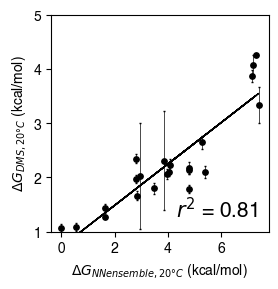

In [46]:
## NNensemble vs. DMS correlation
fourU_ensemble_merged = dms_dG.merge(fourU_ensemble, left_on=['site', 'disp_name'], right_on=['site', 'var'], how='inner', suffixes=('', '_dave')).sort_values(by=['site', 'disp_name'])
plot_linear_correlation(fourU_ensemble_merged, 'dG_dave', 'dG', 'dG_err_dave', 'dG_err', 'NNensemble', 'DMS', '4U', 20)

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 16
    # variables        = 2
    chi-square         = 12.1945326
    reduced chi-square = 0.87103804
    Akaike info crit   = -0.34561629
    Bayesian info crit = 1.19956116
    R-squared          = 0.84283064
[[Variables]]
    slope:      1.30373269 +/- 0.15046598 (11.54%) (init = 1.303733)
    intercept: -1.81373432 +/- 0.77412872 (42.68%) (init = -1.813734)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9535
Saving figure as 4U_NMR_v_NNensemble.pdf


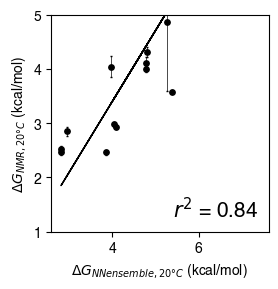

In [47]:
## Mathews NNensemble corr against imino

nnensemble_v_imino = fourU_ensemble.merge(imino_proton, left_on=['site', 'var'], right_on=['site_comp', 'var'], how='inner', suffixes=('_dave', '_imino')).sort_values(by=['site', 'var'])
plot_linear_correlation(nnensemble_v_imino, 'dG_dave', 'dG_imino', 'dG_err_dave', 'dG_err_imino', 'NNensemble', 'NMR', '4U', 20)

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 22
    # variables        = 2
    chi-square         = 8.97432496
    reduced chi-square = 0.44871625
    Akaike info crit   = -15.7268442
    Bayesian info crit = -13.5447593
    R-squared          = 0.46128524
[[Variables]]
    slope:      0.38685954 +/- 0.09348307 (24.16%) (init = 0.3868595)
    intercept:  1.55921678 +/- 0.22167874 (14.22%) (init = 1.559217)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.7648
Saving figure as 4U_DMS_v_NNablation.pdf


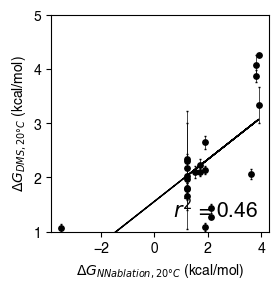

In [48]:
## NNablation vs. DMS correlation
fourU_ablation_merged = dms_dG.merge(fourU_ablation, left_on=['site', 'disp_name'], right_on=['site', 'var'], how='inner', suffixes=('', '_dave')).sort_values(by=['site', 'disp_name'])
plot_linear_correlation(fourU_ablation_merged, 'dG_dave', 'dG', 'dG_err_dave', 'dG_err', 'NNablation', 'DMS', '4U', 20)

### fourU ddG plots

In [49]:
def calc_ddG(df, site_name, col_name, wt_name, a8c_name):
    main_wt = df[df[col_name] == wt_name]
    main_a8c = df[df[col_name] == a8c_name]

    merged_df = pd.merge(main_wt, main_a8c, on=site_name, suffixes=('_wt', '_a8c'))[[site_name, 'dG_wt', 'dG_err_wt', 'dG_a8c', 'dG_err_a8c']]
    merged_df['ddG'] = merged_df['dG_a8c'] - merged_df['dG_wt']
    merged_df['ddG_err'] = np.sqrt(merged_df['dG_err_wt']**2 + merged_df['dG_err_a8c']**2)

    return merged_df

def plot_fit_ddG(merged_df, x_col = 'ddG', y_col = 'ddG_imino', x_err_col = 'ddG_err', y_err_col = 'ddG_err_imino', x_label = 'DMS', y_label = 'NMR', construct = '4U', temp = 20):
    linear_model = LinearModel()
    params = linear_model.guess(merged_df[y_col], x=merged_df[x_col])
    result = linear_model.fit(merged_df[y_col], params, x=merged_df[x_col])

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(merged_df[x_col], merged_df[y_col], color = 'black', s = 15)
    ax.plot(merged_df[x_col], result.best_fit, color = 'black', linewidth = 1)

    # plot errors
    for i in range(len(merged_df)):
        x = merged_df[x_col].iloc[i]
        y = merged_df[y_col].iloc[i]
        x_err = merged_df[x_err_col].iloc[i]
        y_err = merged_df[y_err_col].iloc[i]
        ax.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='none', color='black', capsize=1, elinewidth=0.5)

    label = r'$\Delta \Delta G_{XXX, TTT°C}$ (kcal/mol)'
    label = label.replace('TTT', str(temp))

    ax.set_xlabel(label.replace('XXX', x_label))
    ax.set_ylabel(label.replace('XXX', y_label))

    # annotate r2 bottom left
    r2 = result.rsquared
    ax.annotate(f'$r^2$ = {r2:.2f}', xy=(0.95, 0.05), xycoords='axes fraction', fontsize=15, ha='right', va='bottom')
    plt.tight_layout()
    plt.savefig(f'{construct}_{y_label}_v_{x_label}_ddG.pdf')
    print('Saving figure as ' + f'{construct}_{y_label}_v_{x_label}.pdf')
    plt.show()

In [50]:
imino_ddG = calc_ddG(imino_proton, 'site_comp', 'var', '4U_wt', '4U_a8c')

In [51]:
nn_pen1['dG'] = nn_pen1['dG'].astype(float)
nn_pen1['dG_err'] = nn_pen1['dG_err'].astype(float)
nn_pen1_ddG = calc_ddG(nn_pen1, 'site', 'var', '4U_wt', '4U_a8c')

In [52]:
fourU_ensemble['dG_err'] = 0
nn_ensemble_ddG = calc_ddG(fourU_ensemble, 'site', 'var', '4U_wt', '4U_a8c')

In [53]:
fourU_ablation['dG_err'] = 0
nn_ablation_ddG = calc_ddG(fourU_ablation, 'site', 'var', '4U_wt', '4U_a8c')

Saving figure as 4U_DMS_v_NMR.pdf


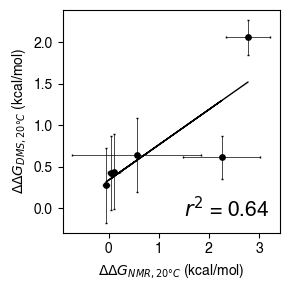

In [54]:
dms_v_imino = dms_ddG.merge(imino_ddG, left_on=['site'], right_on=['site_comp'], how='inner', suffixes=('', '_imino')).sort_values(by=['site'])
plot_fit_ddG(dms_v_imino, x_col = 'ddG_imino', y_col = 'ddG', x_err_col = 'ddG_err_imino', y_err_col = 'ddG_err', x_label = 'NMR', y_label = 'DMS')

Saving figure as 4U_DMS_v_NNpen.pdf


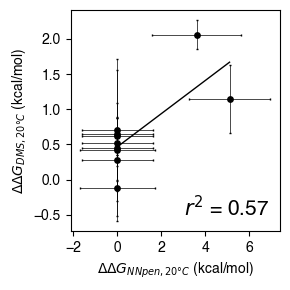

In [55]:
dms_v_nnpen = dms_ddG.merge(nn_pen1_ddG, left_on=['site'], right_on=['site'], how='inner', suffixes=('', '_nnpen')).sort_values(by=['site'])
plot_fit_ddG(dms_v_nnpen, x_col = 'ddG_nnpen', y_col = 'ddG', x_err_col = 'ddG_err_nnpen', y_err_col = 'ddG_err', x_label = 'NNpen', y_label = 'DMS')

Saving figure as 4U_DMS_v_NNensemble.pdf


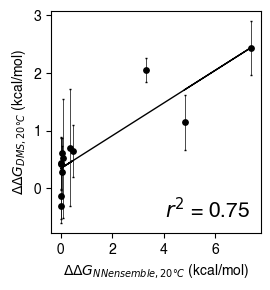

In [56]:
dms_v_nnensemble = dms_ddG.merge(nn_ensemble_ddG, left_on=['site'], right_on=['site'], how='inner', suffixes=('', '_nnensemble')).sort_values(by=['site'])
plot_fit_ddG(dms_v_nnensemble, x_col = 'ddG_nnensemble', y_col = 'ddG', x_err_col = 'ddG_err_nnensemble', y_err_col = 'ddG_err', x_label = 'NNensemble', y_label = 'DMS')

Saving figure as 4U_DMS_v_NNablation.pdf


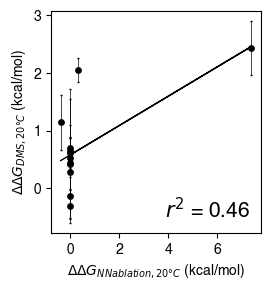

In [57]:
dms_v_nnablation = dms_ddG.merge(nn_ablation_ddG, left_on=['site'], right_on=['site'], how='inner', suffixes=('', '_nnablation')).sort_values(by=['site'])
plot_fit_ddG(dms_v_nnablation, x_col = 'ddG_nnablation', y_col = 'ddG', x_err_col = 'ddG_err_nnablation', y_err_col = 'ddG_err', x_label = 'NNablation', y_label = 'DMS')

Saving figure as 4U_NMR_v_NNensemble.pdf


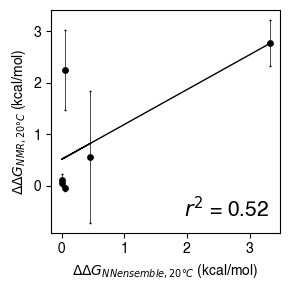

In [58]:
# nnensemble vs. nmr
nnensemble_v_imino_ddG = nn_ensemble_ddG.merge(imino_ddG, left_on=['site'], right_on=['site_comp'], how='inner', suffixes=('', '_imino')).sort_values(by=['site'])
plot_fit_ddG(nnensemble_v_imino_ddG, x_col = 'ddG', y_col = 'ddG_imino', x_err_col = 'ddG_err', y_err_col = 'ddG_err_imino', x_label = 'NNensemble', y_label = 'NMR')

### HIV dG correlation

In [59]:
hiv_dms_dG = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/08_dG_barplots/hiv_calc_dG.csv')

# calc mean of replicates

def mean_with_error(group):
    dG_mean = group['dG'].mean()
    dG_err = np.sqrt((group['dG_err']**2).sum()) / len(group)
    return pd.Series({'dG_mean': dG_mean, 'dG_err_mean': dG_err})

hiv_dms_dG = hiv_dms_dG.groupby(['site', 'disp_name']).apply(mean_with_error).reset_index()
hiv_dms_dG.rename(columns={'dG_mean': 'dG', 'dG_err_mean': 'dG_err'}, inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/08_dG_barplots/hiv_calc_dG.csv'

In [ ]:
# preprocess nn ensemble
mathews_dir = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/09_dG_correlations/reference/01.064.mathews_NN_energies'

hiv_constructs = {'HIV_A35G': 'hiv_a35g', 'HIV_C30U': 'hiv_c30u', 'HIV_WT': 'hiv_wt', 'HIV_UUCGGS': 'hiv_gs', 'HIV_UUCGES': 'hiv_es'}
hiv_ensemble = pd.DataFrame()

for construct, var in hiv_constructs.items():
    mathews_df = pd.read_csv(f'{mathews_dir}/{construct}ensemble.out', sep = '\t')
    mathews_df.rename(columns={'nucleotide#': 'site', 'DG': 'dG'}, inplace=True)
    mathews_df['dG_err'] = 0
    mathews_df['var'] = var
    #mathews_df = mathews_df[['site', 'var', 'dG', 'dG_err']]
    hiv_ensemble = pd.concat([hiv_ensemble, mathews_df], ignore_index=True)


# for sites above 3, add 13 to site
hiv_ensemble['site'] = hiv_ensemble['site'].astype(int)
hiv_ensemble['site'] = hiv_ensemble['site'].apply(lambda x: x + 13 if x > 3 else x)

# if var == 'hiv_gs', all sites above 33 needs to be + 2
hiv_ensemble['site'] = hiv_ensemble.apply(lambda row: row['site'] + 2 if row['var'] == 'hiv_gs' and row['site'] > 33 else row['site'], axis=1)
hiv_ensemble['site'] = hiv_ensemble.apply(lambda row: row['site'] - 2 if row['var'] == 'hiv_es' and row['site'] > 33 else row['site'], axis=1)

# if var == 'hiv_es' replace site 33 with 53
hiv_ensemble['site'] = hiv_ensemble.apply(lambda row: 53 if row['var'] == 'hiv_es' and row['site'] == 33 else row['site'], axis=1)

# replace hiv_es with hiv_es2
hiv_ensemble['var'] = hiv_ensemble['var'].replace({'hiv_es': 'hiv_es2'})

In [ ]:
## NNensemble vs. DMS correlation
hiv_ensemble_merged = hiv_ensemble.merge(hiv_dms_dG, left_on=['site', 'var'], right_on=['site', 'disp_name'], how='inner', suffixes=('_dave', '')).sort_values(by=['site', 'disp_name'])
# filter dG_dave values greater than 0
hiv_ensemble_merged = hiv_ensemble_merged[hiv_ensemble_merged['dG_dave'] > 0]
plot_linear_correlation(hiv_ensemble_merged, 'dG_dave', 'dG', 'dG_err_dave', 'dG_err', 'NNensemble', 'DMS', 'HIV', 25)

In [ ]:
# filter to lengths in lower stem

filter_lowerstem = hiv_ensemble_merged[hiv_ensemble_merged['site'].isin([19, 20, 22, 41, 44, 45])]
filter_lowerstem = hiv_ensemble_merged[hiv_ensemble_merged['site'].isin([19, 20, 22])]

# filter disp_name hiv_wt
filter_lowerstem = filter_lowerstem[filter_lowerstem['disp_name'].isin(['hiv_wt', 'hiv_c30u', 'hiv_a35g', 'hiv_gs', 'hiv_es2'])]
plot_linear_correlation(filter_lowerstem, 'dG_dave', 'dG', 'dG_err_dave', 'dG_err', 'NNensemble', 'DMS', 'HIV_19-20-22', 25)

In [ ]:
# filter to lengths in lower stem

#filter_lowerstem = hiv_ensemble_merged[hiv_ensemble_merged['site'].isin([19, 20, 22, 41, 44, 45])]
filter_lowerstem = hiv_ensemble_merged[hiv_ensemble_merged['site'].isin([41, 44, 45])]

# filter disp_name hiv_wt
filter_lowerstem = filter_lowerstem[filter_lowerstem['disp_name'].isin(['hiv_wt', 'hiv_c30u', 'hiv_a35g', 'hiv_gs', 'hiv_es2'])]
plot_linear_correlation(filter_lowerstem, 'dG_dave', 'dG', 'dG_err_dave', 'dG_err', 'NNensemble', 'DMS', 'HIV_41-44-45', 25)

In [ ]:
def compare_hiv_vars(hiv_ensemble_merged, x_var, y_var, lower_stem = False):
    if lower_stem:
        filter_lowerstem = hiv_ensemble_merged[hiv_ensemble_merged['site'].isin([19, 20, 22,41, 44, 45])]
    elif lower_stem == 'all':
        filter_lowerstem = hiv_ensemble_merged
    else:
        filter_lowerstem = hiv_ensemble_merged[~hiv_ensemble_merged['site'].isin([19, 20, 22,41, 44, 45])]

    filter_lowerstem_xvar = filter_lowerstem[filter_lowerstem['disp_name'].isin([x_var])]
    filter_lowerstem_yvar = filter_lowerstem[filter_lowerstem['disp_name'].isin([y_var])]

    # merge on site
    filter_lowerstem = pd.merge(filter_lowerstem_xvar, filter_lowerstem_yvar, on='site', suffixes=('_x', '_y'))


    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(filter_lowerstem['dG_x'], filter_lowerstem['dG_y'])

    # plot x=y line
    x = np.linspace(min(filter_lowerstem['dG_x']), max(filter_lowerstem['dG_x']), 100)
    ax.plot(x, x, color='black', linestyle='--', linewidth=1)

    ax.set_xlabel(f'{x_var} dG')
    ax.set_ylabel(f'{y_var} dG')
    plt.show()

compare_hiv_vars(hiv_ensemble_merged, 'hiv_wt', 'hiv_gs', lower_stem = 'all')

### P4P6 correlations

In [ ]:
def select_sites_by_buffer(df, site_buffer_dict):
    """
    Select rows from df where (site, buffer) matches any in the site_buffer_dict.

    Parameters:
        df (pd.DataFrame): Must contain 'site' and 'buffer' columns.
        site_buffer_dict (dict): Keys are site integers, values are lists of allowed buffers.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    # Convert dictionary into a set of (site, buffer) pairs to match
    allowed_pairs = {(site, buf) for site, buffers in site_buffer_dict.items() for buf in buffers}
    
    # Create a mask where each row's (site, buffer) pair is in allowed_pairs
    mask = df.apply(lambda row: (row['site'], row['buffer']) in allowed_pairs, axis=1)
    
    return df[mask].copy()

In [ ]:
dG_df = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/11_dG_scale_classification/reference/23_modrate_MRT_fit_with_error.csv')

# canonical WC
wcf_select = {
    161: [13, 14], 159: [13, 14], 154: [13, 14], 146: [13, 14],
    145: [13], 229: [13, 14], 232: [13, 14], 230: [13, 14],
    231: [13, 14], 233: [13, 14], 246: [13, 14], 240: [13],
    166: [13], 165: [13], 173: [13], 127: [13], 128: [13]
}

dG_df = select_sites_by_buffer(dG_df, wcf_select) # select canonical only
dG_df['disp_name'] = 'p4p6_wt'

# filter for buffer 13 only
dG_df_13 = dG_df[dG_df['buffer'] == 13]
dG_df_14 = dG_df[dG_df['buffer'] == 14]

In [ ]:
# preprocess nn ensemble
mathews_dir = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/09_dG_correlations/reference/01.064.mathews_NN_energies'

p4p6_ensemble = pd.read_csv(f'{mathews_dir}/P4P6_wt_nobcensemble.out', sep = '\t')
p4p6_ensemble.rename(columns={'nucleotide#': 'site', 'DG': 'dG'}, inplace=True)
p4p6_ensemble['dG_err'] = 0
p4p6_ensemble['var'] = 'p4p6_wt'
p4p6_ensemble['site'] += 98 # adjust site numbers to match DMS
p4p6_ensemble = p4p6_ensemble[['site', 'var', 'dG', 'dG_err']]

In [ ]:
## NNensemble vs. DMS correlation
p4p6_ensemble_merged = p4p6_ensemble.merge(dG_df_13, left_on=['site', 'var'], right_on=['site', 'disp_name'], how='inner', suffixes=('_dave', '')).sort_values(by=['site', 'disp_name'])
plot_linear_correlation(p4p6_ensemble_merged, 'dG_dave', 'dG', 'dG_err_dave', 'dG_err', 'NNensemble', 'DMS', 'P4P6', 25)

In [ ]:
p4p6_ensemble_merged.to_csv('p4p6_ensemble_merged_13.csv', index=False)

In [ ]:
## NNensemble vs. DMS correlation
p4p6_ensemble_merged = p4p6_ensemble.merge(dG_df_14, left_on=['site', 'var'], right_on=['site', 'disp_name'], how='inner', suffixes=('_dave', '')).sort_values(by=['site', 'disp_name'])
plot_linear_correlation(p4p6_ensemble_merged, 'dG_dave', 'dG', 'dG_err_dave', 'dG_err', 'NNensemble', 'DMS', 'P4P6', 25)

In [ ]:
p4p6_select_sigdiff = dG_df[dG_df['site'].isin([230, 231, 232, 233, 252])]
## NNensemble vs. DMS correlation
p4p6_ensemble_merged = p4p6_ensemble.merge(p4p6_select_sigdiff, left_on=['site', 'var'], right_on=['site', 'disp_name'], how='inner', suffixes=('_dave', '')).sort_values(by=['site', 'disp_name'])
plot_linear_correlation(p4p6_ensemble_merged, 'dG_dave', 'dG', 'dG_err_dave', 'dG_err', 'NNensemble', 'DMS', 'P4P6_new', 25)

In [ ]:
p4p6_ensemble_merged.to_csv('p4p6_ensemble_merged_14.csv', index=False)

### Correlation matrix (dG, fourU)

In [ ]:
calculate_r2_from_fit(merged_dG,'dG_imino', 'dG', 'NMR', 'DMS')

In [ ]:
def get_corr_between_dataset(datasets_dict, x_dataset, y_dataset):
    x_data, x_keys, x_label = datasets_dict[x_dataset]
    y_data, y_keys, y_label = datasets_dict[y_dataset]

    if x_label == 'endpt':
        x_data['dG'] = x_data['lnendpt_10mins'].copy()
    
    if y_label == 'endpt':
        y_data['dG'] = y_data['lnendpt_10mins'].copy()

    # Merge the two datasets on the specified keys
    merged_data = pd.merge(x_data, y_data, left_on=x_keys, right_on=y_keys, how='inner', suffixes=('', '_y')).sort_values(by=x_keys)

    # Calculate the correlation coefficient
    r2 = calculate_r2_from_fit(merged_data, 'dG', 'dG_y', x_label, y_label)

    # Print the correlation coefficient
    print(f'Correlation between {x_label} and {y_label}: {r2:.3f}')

    return r2

In [ ]:
datasets_dict = {
    'imino': [imino_proton, ['site_comp', 'var'], 'NMR'],
    'dms_dG': [dms_dG, ['site', 'disp_name'], 'DMS'],
    'dms_endpt': [dms_endpt, ['site', 'disp_name'], 'endpt'],
    'dms_pseudo': [pseudo_dms, ['site', 'disp_name'], 'endpt2'],
    'nn_pen': [nn_pen1, ['site', 'var'], 'NNpen'],
    'nn_ensem': [fourU_ensemble, ['site', 'var'], 'NNensemble'],
    'nn_ablation': [fourU_ablation, ['site', 'var'], 'NNablation'],
}

# calculate correlation matrix between datasets
corr_matrix = pd.DataFrame(index=datasets_dict.keys(), columns=datasets_dict.keys())
for x_dataset in datasets_dict.keys():
    for y_dataset in datasets_dict.keys():
        print(f'Calculating correlation between {x_dataset} and {y_dataset}')
        if x_dataset == y_dataset:
            corr_matrix.loc[x_dataset, y_dataset] = 1.0
        else:
            corr_matrix.loc[x_dataset, y_dataset] = get_corr_between_dataset(datasets_dict, x_dataset, y_dataset)
corr_matrix = corr_matrix.astype(float)

# plot in heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Correlation Matrix (R2)')
plt.tight_layout()
plt.savefig('full_correlation_matrix.pdf')

In [ ]:
# for figure

select_methods = ['dms_endpt', 'dms_pseudo', 'dms_dG', 'imino', 'nn_ensem']
labels = ['DMS raw', 'DMS pseudo-∆G', 'DMS ∆G', 'NMR', 'NN']

# calculate correlation matrix between datasets
corr_matrix = pd.DataFrame(index = select_methods, columns = select_methods)

for x_dataset in select_methods:
    for y_dataset in select_methods:
        #print(f'Calculating correlation between {x_dataset} and {y_dataset}')
        if x_dataset == y_dataset:
            corr_matrix.loc[x_dataset, y_dataset] = 1.0
        else:
            corr_matrix.loc[x_dataset, y_dataset] = get_corr_between_dataset(datasets_dict, x_dataset, y_dataset)
corr_matrix = corr_matrix.astype(float)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_matrix)

# plot in heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu_r', cbar_kws={"shrink": .8}, linewidths=1,
xticklabels=labels, yticklabels=labels)
plt.xticks(rotation=30, ha='right')  # rotate x-axis labels
plt.yticks(rotation=0)               # keep y-axis labels horizontal
plt.tight_layout()
plt.savefig('partial_correlation_matrix_select.pdf')
